In [95]:
import pandas as pd
import numpy as np
import os
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. read data

### 1.1 events

In [54]:
event = pd.read_csv("/Users/bowenlong/Desktop/python recommender system/dataset/events.csv")

In [57]:
event[event.event=='transaction'].head()

,timestamp,visitorid,event,itemid,transactionid
130,1433222276276,599528,transaction,356475,4000.0
304,1433193500981,121688,transaction,15335,11117.0
418,1433193915008,552148,transaction,81345,5444.0
814,1433176736375,102019,transaction,150318,13556.0
843,1433174518180,189384,transaction,310791,7244.0


In [56]:
event[event.event=='addtocart'].head()

,timestamp,visitorid,event,itemid,transactionid
17,1433223236124,287857,addtocart,5206,NaN
19,1433221078505,158090,addtocart,10572,NaN
63,1433223543021,1193904,addtocart,255275,NaN
112,1433221941632,599528,addtocart,356475,NaN
179,1433220880956,105775,addtocart,312728,NaN


In [55]:
event[event.event=='view'].head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [5]:
event.dtypes

timestamp          int64
visitorid          int64
event             object
itemid             int64
transactionid    float64
dtype: object

In [6]:
### convert datetime
event['datetime'] = event.timestamp.apply(lambda x: dt.utcfromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))

In [7]:
event.datetime.min()

'2015-05-03 03:00:04'

In [8]:
event.datetime.max()

'2015-09-18 02:59:47'

In [9]:
### vistor id

In [10]:
len(event.visitorid.unique())

1407580

In [11]:
x = event.visitorid.value_counts()

In [12]:
x.describe()

count    1.407580e+06
mean     1.958042e+00
std      1.258049e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      7.757000e+03
Name: visitorid, dtype: float64

In [13]:
### item id

In [14]:
len(event.itemid.unique())

235061

In [15]:
x = event.itemid.value_counts()

In [16]:
x.describe()

count    235061.000000
mean         11.725046
std          37.032101
min           1.000000
25%           1.000000
50%           3.000000
75%           9.000000
max        3412.000000
Name: itemid, dtype: float64

In [17]:
### event

In [18]:
event.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [19]:
event.transactionid.isnull().value_counts()

True     2733644
False      22457
Name: transactionid, dtype: int64

## dedup event

In [20]:
event_dedup = event.groupby(['visitorid', 'itemid', 'timestamp']).first()

In [21]:
event_fnl = event.copy()

## 2. EDA

### 2.1 variables distribution

### vistor

In [66]:
view_ct = event_fnl.visitorid.value_counts()

<AxesSubplot:>

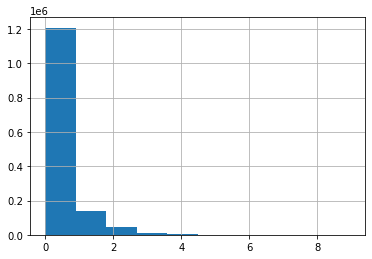

In [67]:
np.log(view_ct.sort_values(ascending = False)).hist()

In [68]:
view_ct.head(20)

1150086    7757
530559     4328
152963     3024
895999     2474
163561     2410
371606     2345
286616     2252
684514     2246
892013     2024
861299     1991
836635     1934
76757      1883
638482     1829
1297062    1822
316850     1752
247235     1698
1161163    1663
994820     1661
79627      1623
518659     1614
Name: visitorid, dtype: int64

In [69]:
### visitor 1150086 

In [70]:
event_fnl[event_fnl.visitorid == 1150086].date.value_counts()

2015-07-14    254
2015-07-22    221
2015-07-15    218
2015-06-29    209
2015-08-15    206
             ... 
2015-08-29      5
2015-08-26      4
2015-08-28      4
2015-08-25      2
2015-08-24      1
Name: date, Length: 74, dtype: int64

### item

In [71]:
item_ct = event_fnl.itemid.value_counts()
item_ct

187946    3412
461686    2978
5411      2334
370653    1854
219512    1800
          ... 
78748        1
317820       1
319096       1
211328       1
2047         1
Name: itemid, Length: 235061, dtype: int64

<AxesSubplot:>

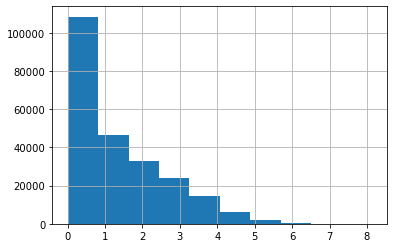

In [72]:
np.log(item_ct.sort_values(ascending = False)).hist()

In [73]:
item_ct.head(20)

187946    3412
461686    2978
5411      2334
370653    1854
219512    1800
257040    1647
298009    1642
96924     1633
309778    1628
384302    1608
320130    1507
7943      1489
111530    1447
441668    1433
335975    1428
234255    1307
190000    1231
151444    1230
37029     1227
369447    1214
Name: itemid, dtype: int64

### event

<AxesSubplot:ylabel='event'>

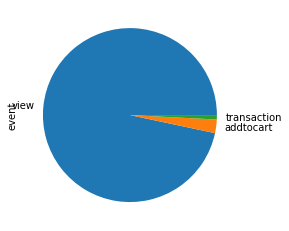

In [74]:
event_fnl.event.value_counts().plot.pie()

In [75]:
event_fnl['pred'] = event_fnl.event.apply(lambda x: 'addtocart' if x in ['transaction', 'addtocart'] else 'view') 

In [76]:
event_fnl.pred.value_counts()

view         2664312
addtocart      91789
Name: pred, dtype: int64

### 2.2 Insights

### previous bought items

In [22]:
### history list of each customer and items customers currently viewing

In [23]:
event_fnl.head()

,timestamp,visitorid,event,itemid,transactionid,datetime
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17


In [24]:
event_fnl = event_fnl.sort_values(['visitorid', 'itemid', 'timestamp'], ascending=[True, True, True])

In [25]:
event_fnl[event_fnl.visitorid == 1150086].event.value_counts()

view           6479
addtocart       719
transaction     559
Name: event, dtype: int64

In [26]:
event_fnl[(event_fnl.itemid == 427254)&(event_fnl.visitorid == 1152713)&(event_fnl.timestamp == 1435308445514)]

,timestamp,visitorid,event,itemid,transactionid,datetime
537331,1435308445514,1152713,view,427254,NaN,2015-06-26 08:47:25
542622,1435308445514,1152713,view,427254,NaN,2015-06-26 08:47:25
546124,1435308445514,1152713,view,427254,NaN,2015-06-26 08:47:25


In [27]:
###dedup

In [28]:
event_fnl_dedup = event_fnl.groupby(['visitorid', 'itemid', 'timestamp']).first().reset_index()

In [29]:
event_fnl_dedup.head()

,visitorid,itemid,timestamp,event,transactionid,datetime
0,0,67045,1442004917175,view,NaN,2015-09-11 20:55:17
1,0,285930,1442004589439,view,NaN,2015-09-11 20:49:49
2,0,357564,1442004759591,view,NaN,2015-09-11 20:52:39
3,1,72028,1439487966444,view,NaN,2015-08-13 17:46:06
4,2,216305,1438970468920,view,NaN,2015-08-07 18:01:08


In [30]:
event_fnl_dedup.shape

(2755630, 6)

In [31]:
event_fnl.shape

(2756101, 6)

In [32]:
### previous bought (group by these four variables to make it unique pair)

In [33]:
pre_bought = event_fnl_dedup[event_fnl_dedup.transactionid.notna()][['visitorid', 'itemid', 'transactionid', 'timestamp']].rename(
columns={"itemid": "bought_item", "timestamp": "bought_time", 'transactionid': 'bought_id'})

In [34]:
pre_bought

,visitorid,bought_item,bought_id,bought_time
333,172,10034,9725.0,1439602141686
364,172,465522,9725.0,1439602141230
384,186,49029,8726.0,1439397297040
496,264,161949,8445.0,1441647285708
499,264,459835,8445.0,1441647285614
...,...,...,...,...
2754167,1406787,336832,15915.0,1433177808042
2754555,1406981,436004,686.0,1431988101266
2754697,1407070,215596,5064.0,1431556875160
2754771,1407110,360922,3851.0,1438729885624


In [35]:
### merge with event_fnl_dedup by visitorid

In [36]:
event_fnl_bought = event_fnl_dedup.merge(pre_bought, how = 'left')

In [37]:
event_fnl_bought[event_fnl_bought.bought_item.notna()].head()

,visitorid,itemid,timestamp,event,transactionid,datetime,bought_item,bought_id,bought_time
327,172,10034,1436848989537,view,NaN,2015-07-14 04:43:09,10034.0,9725.0,1.439602e+12
328,172,10034,1436848989537,view,NaN,2015-07-14 04:43:09,465522.0,9725.0,1.439602e+12
329,172,10034,1436849172774,view,NaN,2015-07-14 04:46:12,10034.0,9725.0,1.439602e+12
330,172,10034,1436849172774,view,NaN,2015-07-14 04:46:12,465522.0,9725.0,1.439602e+12
331,172,10034,1436850087714,view,NaN,2015-07-14 05:01:27,10034.0,9725.0,1.439602e+12


In [38]:
### clean

In [39]:
event_fnl_bought.loc[(event_fnl_bought.bought_time>=event_fnl_bought.timestamp)|(event_fnl_bought.bought_id == event_fnl_bought.transactionid), 'bought_item'] = np.nan

In [40]:
event_fnl_bought[event_fnl_bought.bought_item.notna()][['visitorid', 'timestamp', 'bought_time']].head()

,visitorid,timestamp,bought_time
423,186,1439399604184,1.439397e+12
424,186,1439420372345,1.439397e+12
1042,539,1434433315269,1.434433e+12
1043,539,1434433324128,1.434433e+12
1044,539,1434470992149,1.434433e+12


In [41]:
event_fnl_bought[event_fnl_bought.visitorid==186]

,visitorid,itemid,timestamp,event,transactionid,datetime,bought_item,bought_id,bought_time
421,186,49029,1439396896523,addtocart,NaN,2015-08-12 16:28:16,NaN,8726.0,1.439397e+12
422,186,49029,1439397297040,transaction,8726.0,2015-08-12 16:34:57,NaN,8726.0,1.439397e+12
423,186,49029,1439399604184,view,NaN,2015-08-12 17:13:24,49029.0,8726.0,1.439397e+12
424,186,49029,1439420372345,view,NaN,2015-08-12 22:59:32,49029.0,8726.0,1.439397e+12


In [42]:
event_fnl_bought[['visitorid', 'itemid', 'timestamp']].value_counts()

visitorid  itemid  timestamp    
1150086    279280  1439592606011    559
           309336  1441208393468    559
           310944  1438879481058    559
                   1438879344272    559
                   1438879281142    559
                                   ... 
923700     191106  1439772758122      1
923699     218531  1430785688837      1
           20906   1430785628866      1
923698     213949  1431903682344      1
0          67045   1442004917175      1
Length: 2755630, dtype: int64

In [43]:
df = event_fnl_bought.copy()

In [44]:
df[(df.visitorid == 1150086)&(df.itemid == 279280) &(df.timestamp == 1439592606011)].groupby(['visitorid', 'itemid', 'timestamp'])['bought_item'].apply(lambda x: list(np.unique(x)))

visitorid  itemid  timestamp    
1150086    279280  1439592606011    [546.0, 869.0, 1152.0, 1684.0, 1976.0, 4067.0,...
Name: bought_item, dtype: object

In [45]:
### previous item list and merge

In [46]:
prev_item_list = event_fnl_bought.groupby(['visitorid', 'itemid', 'timestamp'])['bought_item'].apply(lambda x: list(np.unique(x)))

In [47]:
prev_item_list = prev_item_list.reset_index()

In [48]:
prev_item_list[prev_item_list.visitorid == 186]

,visitorid,itemid,timestamp,bought_item
383,186,49029,1439396896523,[nan]
384,186,49029,1439397297040,[nan]
385,186,49029,1439399604184,[49029.0]
386,186,49029,1439420372345,[49029.0]


In [49]:
event_fnl.columns

Index(['timestamp', 'visitorid', 'event', 'itemid', 'transactionid',
       'datetime'],
      dtype='object')

In [50]:
event_fnl = event_fnl.merge(prev_item_list, how = 'left')

In [51]:
event_fnl.shape

(2756101, 7)

### most recent view items

In [52]:
event_fnl.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,bought_item
0,1442004917175,0,view,67045,NaN,2015-09-11 20:55:17,[nan]
1,1442004589439,0,view,285930,NaN,2015-09-11 20:49:49,[nan]
2,1442004759591,0,view,357564,NaN,2015-09-11 20:52:39,[nan]
3,1439487966444,1,view,72028,NaN,2015-08-13 17:46:06,[nan]
4,1438970468920,2,view,216305,NaN,2015-08-07 18:01:08,[nan]


In [53]:
event_fnl_dedup.transactionid.value_counts()

7063.0     31
765.0      28
8351.0     27
2753.0     23
6993.0     21
           ..
11745.0     1
11744.0     1
11743.0     1
11742.0     1
0.0         1
Name: transactionid, Length: 17672, dtype: int64

In [54]:
### for view items

In [55]:
lastview_view = event_fnl_dedup[event_fnl_dedup.event == 'view'].sort_values(['visitorid', 'timestamp'], ascending = [True, True])

In [56]:
lastview_view.head()

,visitorid,itemid,timestamp,event,transactionid,datetime
1,0,285930,1442004589439,view,NaN,2015-09-11 20:49:49
2,0,357564,1442004759591,view,NaN,2015-09-11 20:52:39
0,0,67045,1442004917175,view,NaN,2015-09-11 20:55:17
3,1,72028,1439487966444,view,NaN,2015-08-13 17:46:06
7,2,325215,1438969904567,view,NaN,2015-08-07 17:51:44


In [57]:
lastview_view['lastview_item1']=lastview_view.groupby('visitorid')['itemid'].shift(1)
lastview_view['lastview_item2']=lastview_view.groupby('visitorid')['itemid'].shift(2)
lastview_view['lastview_item3']=lastview_view.groupby('visitorid')['itemid'].shift(3)

In [58]:
from collections import Counter

In [59]:
lastview_view['lastview_item'] = lastview_view[['lastview_item1', 'lastview_item2', 'lastview_item3']].values.tolist()

In [60]:
"""x = [np.nan, 2, np.nan]
[y if np.isnan(y) == False else 3 for y in x ]"""

'x = [np.nan, 2, np.nan]\n[y if np.isnan(y) == False else 3 for y in x ]'

In [61]:
### remove nan in list

In [62]:
lastview_view['lastview_item'] = lastview_view['lastview_item'].apply(lambda x: [y for y in x if np.isnan(y) == False])

In [63]:
lastview_view[['visitorid', 'itemid', 'timestamp', 'lastview_item']].head()

,visitorid,itemid,timestamp,lastview_item
1,0,285930,1442004589439,[]
2,0,357564,1442004759591,[285930.0]
0,0,67045,1442004917175,"[357564.0, 285930.0]"
3,1,72028,1439487966444,[]
7,2,325215,1438969904567,[]


In [64]:
#### for non-view items

In [65]:
lastview_addcart = event_fnl_dedup[event_fnl_dedup.event != 'view'].sort_values(['visitorid', 'timestamp'], ascending = [True, True])

In [66]:
lastview_addcart.head()

,visitorid,itemid,timestamp,event,transactionid,datetime
15,6,65273,1440914628202,addtocart,NaN,2015-08-30 06:03:48
278,150,452955,1433719818230,addtocart,NaN,2015-06-07 23:30:18
293,155,368372,1441951932678,addtocart,NaN,2015-09-11 06:12:12
297,155,452082,1441951937583,addtocart,NaN,2015-09-11 06:12:17
291,155,181405,1441951967871,addtocart,NaN,2015-09-11 06:12:47


In [67]:
### step-by-step to find last view item

In [68]:
df1 = lastview_addcart.merge(lastview_view[['visitorid', 'itemid', 'timestamp']].rename(
columns={"itemid": "lastview_item", "timestamp": "lastview_time"}), how = 'left')

In [69]:
df1.head()

,visitorid,itemid,timestamp,event,transactionid,datetime,lastview_item,lastview_time
0,6,65273,1440914628202,addtocart,NaN,2015-08-30 06:03:48,253615.0,1.440917e+12
1,6,65273,1440914628202,addtocart,NaN,2015-08-30 06:03:48,344723.0,1.440917e+12
2,6,65273,1440914628202,addtocart,NaN,2015-08-30 06:03:48,344723.0,1.440918e+12
3,6,65273,1440914628202,addtocart,NaN,2015-08-30 06:03:48,344723.0,1.440918e+12
4,6,65273,1440914628202,addtocart,NaN,2015-08-30 06:03:48,344723.0,1.440991e+12


In [70]:
df2 = df1[df1.lastview_time<df1.timestamp]

In [71]:
df2['lastview_time_diff'] = df2['timestamp'] - df2['lastview_time']

<ipython-input-71-c46d0f0f3865>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['lastview_time_diff'] = df2['timestamp'] - df2['lastview_time']


In [72]:
df3 = df2.groupby(['visitorid', 'itemid', 'timestamp'])['lastview_time_diff'].nsmallest(3)

In [73]:
df3 = df3.reset_index()

In [74]:
df3.columns

Index(['visitorid', 'itemid', 'timestamp', 'level_3', 'lastview_time_diff'], dtype='object')

In [75]:
### merge get lastview_item (most recent 3)

In [76]:
df4 = df2[['visitorid', 'itemid', 'timestamp', 'lastview_item', 'lastview_time_diff']].merge(df3, how = 'left')

In [77]:
df5 = df4[df4.level_3.notna()].groupby(['visitorid', 'itemid', 'timestamp'])['lastview_item'].apply(lambda x: list(np.unique(x))).reset_index()

In [78]:
### merge

In [79]:
lastview_item_list = lastview_addcart[['visitorid', 'itemid', 'timestamp']].merge(df5, how = 'left').append(lastview_view[['visitorid', 'itemid', 'timestamp', 'lastview_item']])

### item viewed before, viewed times, time from first view, time from last view

In [81]:
cur_view = event_fnl_dedup[['visitorid', 'itemid', 'timestamp', 'event']].copy().rename(columns = {'timestamp': 'curview_time', 'event': 'cur_event'})

In [82]:
prev_view = event_fnl_dedup[['visitorid', 'itemid', 'timestamp', 'event']].copy().rename(columns = {'timestamp': 'preview_time', 'event': 'prev_event'})

In [83]:
prev_view['match'] = 1

In [84]:
cur_view.head()

,visitorid,itemid,curview_time,cur_event
0,0,67045,1442004917175,view
1,0,285930,1442004589439,view
2,0,357564,1442004759591,view
3,1,72028,1439487966444,view
4,2,216305,1438970468920,view


In [85]:
viewmatch = cur_view.merge(prev_view, how = 'left')

In [86]:
#### step by step remove

In [87]:
viewmatch.shape

(6792660, 7)

In [88]:
df1 = viewmatch[(viewmatch.curview_time>viewmatch.preview_time)&(viewmatch.prev_event=='view')]

In [89]:
df1.head()

,visitorid,itemid,curview_time,cur_event,preview_time,prev_event,match
6,2,216305,1438971463170,view,1438970468920,view,1
12,2,325215,1438970013790,view,1438969904567,view,1
15,2,325215,1438971657845,view,1438969904567,view,1
16,2,325215,1438971657845,view,1438970013790,view,1
20,2,342816,1438971444375,view,1438970905669,view,1


In [90]:
viewtimes = df1.groupby(['visitorid', 'itemid', 'curview_time']).match.count().reset_index().rename(columns = {'match': 'previewtimes'})

In [91]:
viewtimes.previewtimes.sum()

1904878

In [92]:
df1.dtypes

visitorid        int64
itemid           int64
curview_time     int64
cur_event       object
preview_time     int64
prev_event      object
match            int64
dtype: object

In [93]:
df1['preview_time_dif'] = df1['curview_time'] - df1['preview_time']

<ipython-input-93-220ab9f1eac1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['preview_time_dif'] = df1['curview_time'] - df1['preview_time']


In [94]:
df2 = df1.sort_values(['visitorid', 'itemid', 'curview_time', 'preview_time_dif'], ascending = [True, True, True, False]).\
groupby(['visitorid', 'itemid', 'curview_time'])['preview_time_dif'].first().reset_index()

In [95]:
df2['firstview_dif'] = df2['preview_time_dif']/60000

In [96]:
firstview = df2[['visitorid', 'itemid', 'curview_time', 'firstview_dif']]

In [97]:
### time from last view (min)

In [98]:
df3 = df1.sort_values(['visitorid', 'itemid', 'curview_time', 'preview_time_dif'], ascending = [True, True, True, False]).\
groupby(['visitorid', 'itemid', 'curview_time'])['preview_time_dif'].last().reset_index()

In [99]:
df3['lastview_dif'] = df3['preview_time_dif']/60000

In [100]:
lastview = df3[['visitorid', 'itemid', 'curview_time', 'lastview_dif']]

In [101]:
firstview

,visitorid,itemid,curview_time,firstview_dif
0,2,216305,1438971463170,16.570833
1,2,325215,1438970013790,1.820383
2,2,325215,1438971657845,29.221300
3,2,342816,1438971444375,8.978433
4,6,344723,1440917649385,13.759667
...,...,...,...,...
601979,1407530,455539,1437964161007,359.219167
601980,1407537,156770,1437505896838,35.931017
601981,1407560,240708,1436072351277,0.788100
601982,1407572,122041,1431738322384,7110.542833


In [102]:
lastview

,visitorid,itemid,curview_time,lastview_dif
0,2,216305,1438971463170,16.570833
1,2,325215,1438970013790,1.820383
2,2,325215,1438971657845,27.400917
3,2,342816,1438971444375,8.978433
4,6,344723,1440917649385,13.759667
...,...,...,...,...
601979,1407530,455539,1437964161007,359.219167
601980,1407537,156770,1437505896838,35.931017
601981,1407560,240708,1436072351277,0.788100
601982,1407572,122041,1431738322384,7110.542833


### previous addtocart items

In [103]:
event_fnl_dedup.head()

,visitorid,itemid,timestamp,event,transactionid,datetime
0,0,67045,1442004917175,view,NaN,2015-09-11 20:55:17
1,0,285930,1442004589439,view,NaN,2015-09-11 20:49:49
2,0,357564,1442004759591,view,NaN,2015-09-11 20:52:39
3,1,72028,1439487966444,view,NaN,2015-08-13 17:46:06
4,2,216305,1438970468920,view,NaN,2015-08-07 18:01:08


In [104]:
event_fnl_dedup.event.value_counts()

view           2664212
addtocart        68961
transaction      22457
Name: event, dtype: int64

In [105]:
event_fnl_dedup[['visitorid', 'itemid', 'timestamp']].value_counts()

visitorid  itemid  timestamp    
1407579    2521    1435184526978    1
468309     233971  1435864972204    1
           240405  1433270820140    1
                   1433184547895    1
                   1432925823272    1
                                   ..
935325     104730  1430959438112    1
                   1430959428453    1
           104634  1430963009931    1
           98835   1431035593894    1
0          67045   1442004917175    1
Length: 2755630, dtype: int64

In [106]:
pre_add = event_fnl_dedup[event_fnl_dedup.event == 'addtocart'][['visitorid', 'itemid', 'timestamp']].rename(
columns={"itemid": "addcart_item", "timestamp": "addcart_time"})

In [107]:
pre_add

,visitorid,addcart_item,addcart_time
15,6,65273,1440914628202
278,150,452955,1433719818230
284,155,41882,1441952264613
291,155,181405,1441951967871
292,155,224623,1441952340395
...,...,...,...
2755520,1407512,326819,1432953176327
2755522,1407512,334964,1432953337757
2755527,1407512,398091,1432954196910
2755529,1407512,398533,1432954281393


In [108]:
### merge with event_fnl_dedup by visitorid

In [109]:
event_fnl_addcart = event_fnl_dedup.merge(pre_add, how = 'left')

In [110]:
### clean

In [111]:
event_fnl_addcart.loc[(event_fnl_addcart.addcart_time>=event_fnl_addcart.timestamp), 'addcart_item'] = np.nan

In [112]:
event_fnl_addcart[event_fnl_addcart.addcart_item.notna()][['visitorid', 'itemid', 'timestamp', 'addcart_item', 'addcart_time']].head()

,visitorid,itemid,timestamp,addcart_item,addcart_time
16,6,253615,1440916778318,65273.0,1.440915e+12
17,6,344723,1440916823805,65273.0,1.440915e+12
18,6,344723,1440917649385,65273.0,1.440915e+12
19,6,344723,1440917793838,65273.0,1.440915e+12
20,6,344723,1440991285697,65273.0,1.440915e+12


In [113]:
event_fnl_addcart[['visitorid', 'itemid', 'timestamp']].value_counts()

visitorid  itemid  timestamp    
1150086    198285  1437864573337    719
           384302  1440116210326    719
           385355  1435353662824    719
                   1435353271006    719
           385148  1437507124642    719
                                   ... 
914438     109420  1438013619171      1
914437     51650   1439908265593      1
                   1439907843717      1
914436     218126  1441106625610      1
0          67045   1442004917175      1
Length: 2755630, dtype: int64

In [114]:
### prev addcart list and merge

In [115]:
prev_add_list = event_fnl_addcart.groupby(['visitorid', 'itemid', 'timestamp'])['addcart_item'].apply(lambda x: list(np.unique(x)))

In [116]:
prev_add_list

visitorid  itemid  timestamp    
0          67045   1442004917175    [nan]
           285930  1442004589439    [nan]
           357564  1442004759591    [nan]
1          72028   1439487966444    [nan]
2          216305  1438970468920    [nan]
                                    ...  
1407575    121220  1433972768922    [nan]
1407576    356208  1433343689991    [nan]
1407577    427784  1431899284867    [nan]
1407578    188736  1431825683288    [nan]
1407579    2521    1435184526978    [nan]
Name: addcart_item, Length: 2755630, dtype: object

In [117]:
prev_add_list = prev_add_list.reset_index()

## 3. for target variable and evaluation

### 3.1 items addtocart after this view

In [118]:
### addtocart list of each customer after this view

In [119]:
event_fnl_dedup.event.value_counts()

view           2664212
addtocart        68961
transaction      22457
Name: event, dtype: int64

In [120]:
after_addcart = event_fnl_dedup[event_fnl_dedup.event=='addtocart'][['visitorid', 'itemid', 'timestamp']].rename(
columns={"itemid": "addcart_item", "timestamp": "addcart_time"})

In [121]:
### merge with event_fnl_dedup by visitorid

In [122]:
df1 =  event_fnl_dedup.merge(after_addcart, how = 'left')

In [123]:
#### clean

In [124]:
df1.loc[(df1.addcart_time<df1.timestamp), 'addcart_item'] = np.nan

In [125]:
### afterview item list and merge

In [126]:
after_item_list = df1.groupby(['visitorid', 'itemid', 'timestamp'])['addcart_item'].apply(lambda x: list(np.unique(x)))

## 4. downloading

In [ ]:
## 07/03 - 07/17

In [131]:
event_dnl = event_fnl_dedup[event_fnl_dedup.datetime.between('2015-07-03', '2015-07-18')]

In [134]:
event_dnl.head()

,visitorid,itemid,timestamp,event,transactionid,datetime
14,5,61396,1437097556439,view,NaN,2015-07-17 01:45:56
25,9,222422,1436377007285,view,NaN,2015-07-08 17:36:47
37,20,176623,1436805036364,view,NaN,2015-07-13 16:30:36
58,36,176286,1436804963786,view,NaN,2015-07-13 16:29:23
59,36,176286,1436805168853,view,NaN,2015-07-13 16:32:48


In [135]:
event_dnl.shape

(333360, 6)

### 4.1 items bought before

In [136]:
df1 = event_dnl.merge(prev_item_list, how = 'left')

### 4.2 most recent viewed items (3 or less)

In [140]:
df2 = df1.merge(lastview_item_list, how = 'left')

In [141]:
df2

,visitorid,itemid,timestamp,event,transactionid,datetime,bought_item,lastview_item
0,5,61396,1437097556439,view,NaN,2015-07-17 01:45:56,[nan],[]
1,9,222422,1436377007285,view,NaN,2015-07-08 17:36:47,[nan],[]
2,20,176623,1436805036364,view,NaN,2015-07-13 16:30:36,[nan],[]
3,36,176286,1436804963786,view,NaN,2015-07-13 16:29:23,[nan],[]
4,36,176286,1436805168853,view,NaN,2015-07-13 16:32:48,[nan],[176286.0]
...,...,...,...,...,...,...,...,...
333355,1407560,240708,1436072303991,view,NaN,2015-07-05 04:58:23,[nan],[]
333356,1407560,240708,1436072351277,view,NaN,2015-07-05 04:59:11,[nan],[240708.0]
333357,1407564,360760,1436034327075,view,NaN,2015-07-04 18:25:27,[nan],[]
333358,1407569,152860,1436645452554,view,NaN,2015-07-11 20:10:52,[nan],[]


### 4.3 previous addcart items

In [142]:
prev_add_list

,visitorid,itemid,timestamp,addcart_item
0,0,67045,1442004917175,[nan]
1,0,285930,1442004589439,[nan]
2,0,357564,1442004759591,[nan]
3,1,72028,1439487966444,[nan]
4,2,216305,1438970468920,[nan]
...,...,...,...,...
2755625,1407575,121220,1433972768922,[nan]
2755626,1407576,356208,1433343689991,[nan]
2755627,1407577,427784,1431899284867,[nan]
2755628,1407578,188736,1431825683288,[nan]


In [143]:
df3 = df2.merge(prev_add_list, how = 'left')

In [156]:
prev_add_list

,visitorid,itemid,timestamp,addcart_item
0,0,67045,1442004917175,[nan]
1,0,285930,1442004589439,[nan]
2,0,357564,1442004759591,[nan]
3,1,72028,1439487966444,[nan]
4,2,216305,1438970468920,[nan]
...,...,...,...,...
2755625,1407575,121220,1433972768922,[nan]
2755626,1407576,356208,1433343689991,[nan]
2755627,1407577,427784,1431899284867,[nan]
2755628,1407578,188736,1431825683288,[nan]


### 4.4 after_addcart items (for evaluation)

In [159]:
after_item_list = after_item_list.rename("after_addcart_item").to_frame().reset_index()

In [161]:
df4 = df3.merge(after_item_list, how = 'left')

### 4.5 for currently viewing item

In [164]:
### viewtimes

In [166]:
df4.head()

,visitorid,itemid,timestamp,event,transactionid,datetime,bought_item,lastview_item,addcart_item,after_addcart_item
0,5,61396,1437097556439,view,NaN,2015-07-17 01:45:56,[nan],[],[nan],[nan]
1,9,222422,1436377007285,view,NaN,2015-07-08 17:36:47,[nan],[],[nan],[nan]
2,20,176623,1436805036364,view,NaN,2015-07-13 16:30:36,[nan],[],[nan],[nan]
3,36,176286,1436804963786,view,NaN,2015-07-13 16:29:23,[nan],[],[nan],[nan]
4,36,176286,1436805168853,view,NaN,2015-07-13 16:32:48,[nan],[176286.0],[nan],[nan]


In [178]:
df5 = df4.merge(viewtimes.rename(columns = {'curview_time': 'timestamp'}), how='left').\
merge(firstview.rename(columns = {'curview_time': 'timestamp', 'firstview_dif': 'firstview_dif_min'}), how = 'left').\
merge(lastview.rename(columns = {'curview_time': 'timestamp', 'lasttview_dif': 'lastview_dif_min'}), how = 'left')

In [179]:
df5.to_csv('event_20150703_20150717.csv')

In [ ]:
## check

In [2]:
df6 = pd.read_csv('event_20150703_20150717.csv')

In [3]:
del df6['Unnamed: 0']

In [4]:
df6.head()

,visitorid,itemid,timestamp,event,transactionid,datetime,bought_item,lastview_item,addcart_item,after_addcart_item,previewtimes,firstview_dif_min,lastview_dif
0,5,61396,1437097556439,view,NaN,2015-07-17 01:45:56,[nan],[],[nan],[nan],NaN,NaN,NaN
1,9,222422,1436377007285,view,NaN,2015-07-08 17:36:47,[nan],[],[nan],[nan],NaN,NaN,NaN
2,20,176623,1436805036364,view,NaN,2015-07-13 16:30:36,[nan],[],[nan],[nan],NaN,NaN,NaN
3,36,176286,1436804963786,view,NaN,2015-07-13 16:29:23,[nan],[],[nan],[nan],NaN,NaN,NaN
4,36,176286,1436805168853,view,NaN,2015-07-13 16:32:48,[nan],[176286.0],[nan],[nan],1.0,3.417783,3.417783


In [221]:
df6.shape

(333360, 23)

## 5. LightFM Modeling and prediction

In [6]:
from lightfm import LightFM
from lightfm.evaluation import auc_score
from scipy.sparse import coo_matrix
from sklearn import preprocessing
from collections import Counter

### 5.1 modeling

In [6]:
## prepare data

In [7]:
events = df6.sort_values('timestamp').\
reset_index(drop=True)[['visitorid', 'itemid', 'timestamp', 'event']]

In [ ]:
### filter event (view, addtocart)

In [8]:
events = events[events.event.isin(['view', 'addtocart'])]

In [9]:
events.head()

,visitorid,itemid,timestamp,event
0,1067496,401572,1435881606417,view
1,782046,43725,1435881606528,view
2,982670,17218,1435881606734,view
3,35240,119965,1435881612319,view
4,684514,396378,1435881614244,addtocart


In [10]:
## train/test data

In [11]:
split_point = np.int(np.round(events.shape[0]*0.8))

In [12]:
events_train = events.iloc[0:split_point]
events_test = events.iloc[split_point::]

In [13]:
events_train.shape

(264514, 4)

In [14]:
events_test.shape

(66129, 4)

In [15]:
events_test = events_test[(events_test['visitorid'].isin(events_train['visitorid'])) & (events_test['itemid'].isin(events_train['itemid']))]

In [16]:
## transformation

In [17]:
id_cols=['visitorid','itemid']
trans_cat_train=dict()
trans_cat_test=dict()
"""""
for k in id_cols:
    cate_enc_feat = preprocessing.LabelEncoder()
    trans_cat_train[k] = cate_enc_feat.fit_transform(events_train[k].values)
    trans_cat_test[k] = cate_enc_feat.transform(events_test[k].values)"""""

'""\nfor k in id_cols:\n    cate_enc_feat = preprocessing.LabelEncoder()\n    trans_cat_train[k] = cate_enc_feat.fit_transform(events_train[k].values)\n    trans_cat_test[k] = cate_enc_feat.transform(events_test[k].values)'

In [18]:
## for visitorid
cate_enc_vis = preprocessing.LabelEncoder()
trans_cat_train['visitorid'] = cate_enc_vis.fit_transform(events_train['visitorid'].values)
trans_cat_test['visitorid'] = cate_enc_vis.transform(events_test['visitorid'].values)

In [19]:
## for itemid
cate_enc_item = preprocessing.LabelEncoder()
trans_cat_train['itemid'] = cate_enc_item.fit_transform(events_train['itemid'].values)
trans_cat_test['itemid'] = cate_enc_item.transform(events_test['itemid'].values)

In [20]:
events_train['visitorid'].values

array([1067496,  782046,  982670, ..., 1009292,  625167,  831704])

In [21]:
trans_cat_train['visitorid']

array([113387,  82913, 104369, ..., 107209,  66279,  88143])

In [22]:
len(events_test['visitorid'].values)

8325

In [23]:
len(trans_cat_test['visitorid'])

8325

In [24]:
ratings = dict()
cate_enc_score = preprocessing.LabelEncoder()
ratings['train'] = cate_enc_score.fit_transform(events_train.event)
ratings['test'] = cate_enc_score.transform(events_test.event)

In [25]:
events_train.event.value_counts()

view         257968
addtocart      6546
Name: event, dtype: int64

In [26]:
Counter(list(ratings['train']))

Counter({1: 257968, 0: 6546})

In [27]:
### prepare matrix for lightfm

In [28]:
events_train.head()

,visitorid,itemid,timestamp,event
0,1067496,401572,1435881606417,view
1,782046,43725,1435881606528,view
2,982670,17218,1435881606734,view
3,35240,119965,1435881612319,view
4,684514,396378,1435881614244,addtocart


In [29]:
n_users=len(np.unique(trans_cat_train['visitorid']))
n_items=len(np.unique(trans_cat_train['itemid']))

In [30]:
np.unique(trans_cat_train['itemid'])

array([    0,     1,     2, ..., 76340, 76341, 76342])

In [28]:
n_users

149487

In [29]:
n_items

76343

In [32]:
rate_matrix = dict()
rate_matrix['train'] = coo_matrix((ratings['train'], (trans_cat_train['visitorid'], trans_cat_train['itemid'])), shape=(n_users,n_items))
rate_matrix['test'] = coo_matrix((ratings['test'], (trans_cat_test['visitorid'], trans_cat_test['itemid'])), shape=(n_users,n_items))

In [318]:
#events_train['event_num']=events_train['event'].apply(lambda x: 2 if x == 'view' else (0 if x == 'addtocart' else 1))

<ipython-input-318-db0f7be02521>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train['event_num']=events_train['event'].apply(lambda x: 2 if x == 'view' else (0 if x == 'addtocart' else 1))


In [ ]:
## model

In [33]:
model = LightFM(no_components=10, loss='warp')
model.fit(rate_matrix['train'], epochs=100, num_threads=8)

In [ ]:
## predict

In [34]:
n_users, n_items

(149487, 76343)

In [35]:
events_test.visitorid.values

array([ 450856, 1297909, 1038942, ...,  126242,  672218,  126242])

In [36]:
cate_enc_vis.inverse_transform(trans_cat_train['visitorid'])

array([1067496,  782046,  982670, ..., 1009292,  625167,  831704])

In [49]:
auc_score(model, rate_matrix['train'], num_threads=8).mean()

0.9986057

### 5.2 Evaluation

In [ ]:
### select an example with most addtocart items

In [37]:
events_test[events_test.event=='addtocart'].groupby('visitorid')['itemid'].nunique().sort_values()

visitorid
23843       1
930934      1
896688      1
888200      1
883553      1
           ..
757355      8
1297062    20
530559     24
1150086    30
974226     33
Name: itemid, Length: 111, dtype: int64

In [ ]:
#### addtocart items of this visitorid

In [38]:
events_test[events_test.visitorid==974226]

,visitorid,itemid,timestamp,event
267454,974226,450226,1436918475510,view
267494,974226,450226,1436918544619,view
267509,974226,450226,1436918561458,view
267527,974226,120050,1436918593083,view
267540,974226,441645,1436918617970,view
...,...,...,...,...
315560,974226,207907,1437100608452,addtocart
315576,974226,1644,1437100665504,view
315579,974226,126143,1437100676523,view
315880,974226,71286,1437101952815,view


In [39]:
events_test[(events_test.visitorid==974226)&(events_test.event=='addtocart')].itemid.unique()

array([441645, 181102, 108083, 116493, 358565, 279316, 409334, 463002,
       402816, 439963, 207602, 246247, 257308, 114115,  46232, 151471,
       220513, 128146, 228644, 167978, 332005, 287536, 166306,  92361,
        28367, 147879, 119736, 367899,  59772,  94437, 380810,  49692,
       207907])

In [ ]:
### map items to cate id

In [41]:
res = cate_enc_item.transform(events_test[(events_test.visitorid==974226)&(events_test.event=='addtocart')].itemid.unique())

In [42]:
res

array([72251, 29637, 17753, 19120, 58767, 45772, 67097, 75703, 66018,
       71969, 33987, 40352, 42173, 18714,  7568, 24781, 36105, 21013,
       37437, 27479, 54369, 47143, 27198, 15132,  4560, 24215, 19669,
       60285,  9795, 15506, 62440,  8145, 34041])

In [ ]:
### use model to predict

In [43]:
cate_enc_vis.transform(np.array([974226]))

array([103471])

In [349]:
np.arange(n_items)

array([    0,     1,     2, ..., 76351, 76352, 76353])

In [44]:
scores = model.predict(103471, np.arange(n_items))

In [45]:
top33 = pd.Series(np.arange(n_items))[np.argsort(-scores)][:33].values
top33

array([37929,   304, 62429, 71131, 56715,  9477, 14197, 42092, 21571,
       49829, 59814, 21129, 75495,  1095, 65423,  7871, 40891, 35733,
       35825, 28853, 31176, 54474, 74454, 50235, 30827, 27198, 20547,
       39867, 44323, 38828, 41752,  8628, 33444])

In [46]:
btm33 = pd.Series(np.arange(n_items))[np.argsort(scores)][:33].values
btm33

array([ 4307, 60646, 38821,  5377, 13931,  9664, 67449, 58795, 50983,
       32945, 36430, 13704, 61791, 58840, 63710, 21031, 33102, 53319,
       73065, 12191, 29697, 41973,  3352, 28651, 64446, 33836, 58512,
       33420, 74414, 23714, 51292, 25203,  4548])

In [47]:
res == top33

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [48]:
res == btm33

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

## 6. Prediction using customer purchase history

In [34]:
df6.head()

,visitorid,itemid,timestamp,event,transactionid,datetime,bought_item,lastview_item,addcart_item,after_addcart_item,previewtimes,firstview_dif_min,lastview_dif
0,5,61396,1437097556439,view,NaN,2015-07-17 01:45:56,[nan],[],[nan],[nan],NaN,NaN,NaN
1,9,222422,1436377007285,view,NaN,2015-07-08 17:36:47,[nan],[],[nan],[nan],NaN,NaN,NaN
2,20,176623,1436805036364,view,NaN,2015-07-13 16:30:36,[nan],[],[nan],[nan],NaN,NaN,NaN
3,36,176286,1436804963786,view,NaN,2015-07-13 16:29:23,[nan],[],[nan],[nan],NaN,NaN,NaN
4,36,176286,1436805168853,view,NaN,2015-07-13 16:32:48,[nan],[176286.0],[nan],[nan],1.0,3.417783,3.417783


In [35]:
import ast

In [36]:
df6['bought_add_view_item'] = df6['bought_item'].str.replace('nan', '00').apply(lambda x: ast.literal_eval(x)) + \
df6['addcart_item'].str.replace('nan', '00').apply(lambda x: ast.literal_eval(x)) + \
df6['lastview_item'].astype('str').str.replace('nan', '[00]').replace('[]', '[00]').apply(lambda x: ast.literal_eval(x))

In [37]:
df6['bought_add_view_item1'] = df6['bought_add_view_item'].apply(lambda x: list(set(x)))

In [38]:
df6['after_addcart_item1'] = df6['after_addcart_item'].str.replace('nan', '00').apply(lambda x: ast.literal_eval(x)).apply(lambda x: list(set(x)))

In [ ]:
### count overlap elements

In [ ]:
df6['x_y'] = df6['bought_add_view_item1'] + df6['after_addcart_item1']

In [ ]:
df6['x_y_dis'] = df6['x_y'].apply(lambda x: list(set(x)))

In [ ]:
df6['x_y_len'] =  df6['x_y'].apply(lambda x: len(x))

In [ ]:
df6['x_y_dis_len'] = df6['x_y_dis'].apply(lambda x: len(x))

In [ ]:
df6['y_len'] = df6['after_addcart_item1'].apply(lambda x: len(x))

In [ ]:
df6['after_addcart_item1'].astype('str').apply(lambda x: '[0]' not in x).sum()

In [ ]:
df6[df6['after_addcart_item1'].astype('str')!='[0]']

In [ ]:
dfx = df6[df6['after_addcart_item1'].astype('str')!='[0]']

In [ ]:
dfx['pred_len'] = dfx['x_y_len'] - dfx['x_y_dis_len']

In [ ]:
## records with history

In [ ]:
sum(df6['bought_add_view_item1'].astype('str')!='[0]')

In [ ]:
df6.shape[0]

In [ ]:
160821/333360

In [ ]:
## accuracy

In [ ]:
dfx.shape[0]

In [ ]:
dfx[dfx.pred_len>0].shape[0]/dfx.shape[0]

In [ ]:
dfx['pred_len'].sum()/dfx['y_len'].sum()

In [ ]:
df6.shape[0]

## 7. Additional descriptive analysis

In [58]:
df6.head()

,visitorid,itemid,timestamp,event,transactionid,datetime,bought_item,lastview_item,addcart_item,after_addcart_item,...,firstview_dif_min,lastview_dif,bought_add_view_item,bought_add_view_item1,after_addcart_item1,x_y,x_y_dis,x_y_len,x_y_dis_len,y_len
0,5,61396,1437097556439,view,NaN,2015-07-17 01:45:56,[nan],[],[nan],[nan],...,NaN,NaN,"[0, 0, 0]",[0],[0],"[0, 0]",[0],2,1,1
1,9,222422,1436377007285,view,NaN,2015-07-08 17:36:47,[nan],[],[nan],[nan],...,NaN,NaN,"[0, 0, 0]",[0],[0],"[0, 0]",[0],2,1,1
2,20,176623,1436805036364,view,NaN,2015-07-13 16:30:36,[nan],[],[nan],[nan],...,NaN,NaN,"[0, 0, 0]",[0],[0],"[0, 0]",[0],2,1,1
3,36,176286,1436804963786,view,NaN,2015-07-13 16:29:23,[nan],[],[nan],[nan],...,NaN,NaN,"[0, 0, 0]",[0],[0],"[0, 0]",[0],2,1,1
4,36,176286,1436805168853,view,NaN,2015-07-13 16:32:48,[nan],[176286.0],[nan],[nan],...,3.417783,3.417783,"[0, 0, 176286.0]","[0, 176286.0]",[0],"[0, 176286.0, 0]","[0, 176286.0]",3,2,1


In [59]:
df6.columns

Index(['visitorid', 'itemid', 'timestamp', 'event', 'transactionid',
       'datetime', 'bought_item', 'lastview_item', 'addcart_item',
       'after_addcart_item', 'previewtimes', 'firstview_dif_min',
       'lastview_dif', 'bought_add_view_item', 'bought_add_view_item1',
       'after_addcart_item1', 'x_y', 'x_y_dis', 'x_y_len', 'x_y_dis_len',
       'y_len'],
      dtype='object')

### 1. event breakdown

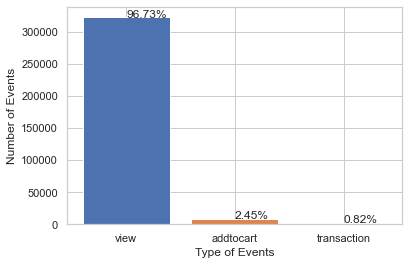

In [123]:
totalcases=df6.shape[0]

fig, ax = plt.subplots(1,1)

for event in df6['event'].unique().tolist():
    height=len(df6[df6['event']==event])
    ax.bar(x=event, height=height)
    
    text=height/totalcases
    text=str(round(text*100,2)) + '%'
    ax.text(event, height, text, fontsize=12)

ax.set_xlabel('Type of Events')
ax.set_ylabel('Number of Events')
plt.show()

### 2. number of times view

In [102]:
#df6[df6.previewtimes.isna()]['previewtimes']=0
df6.loc[df6.previewtimes.isna(), 'previewtimes'] = 0

In [104]:
df6.loc[df6['previewtimes']==0, 'viewtimes_cat'] = 'Instant Purchase'
df6.loc[df6['previewtimes']==1, 'viewtimes_cat'] = '1 View'
df6.loc[df6['previewtimes']==2, 'viewtimes_cat'] = '2 Views'
df6.loc[df6['previewtimes']==3, 'viewtimes_cat'] = '3 Views'
df6.loc[df6['previewtimes']==4, 'viewtimes_cat'] = '4 Views'
df6.loc[df6['previewtimes']>4,  'viewtimes_cat'] = '5 Views and/or above'

In [105]:
df6['purchase'] = 0
df6.loc[df6['event'].isin(['addtocart', 'transaction']), 'purchase'] = 1

In [113]:
n_viw3 = pd.DataFrame(df6[df6.purchase==1]['viewtimes_cat'].value_counts()/df6[df6.purchase==1].shape[0])

In [114]:
n_viw3

,viewtimes_cat
1 View,0.491458
Instant Purchase,0.226396
2 Views,0.156686
3 Views,0.061076
5 Views and/or above,0.039585
4 Views,0.024798


/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1547: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


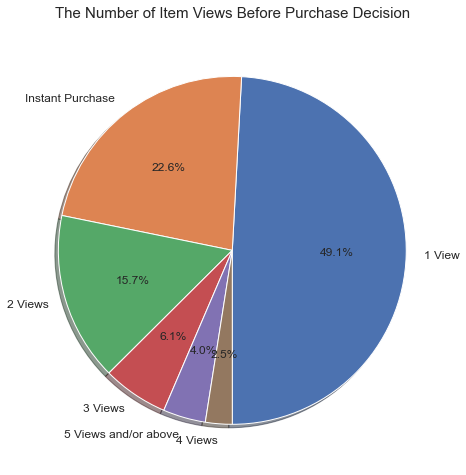

In [122]:
## pie chart
n_viw3.plot(y='viewtimes_cat', kind='pie', autopct='%1.1f%%',  shadow=True, startangle=-90, legend=False, figsize=(8,8), fontsize=12)
plt.title('The Number of Item Views Before Purchase Decision', fontsize=15, pad=15)
plt.ylabel('')
plt.show()

### 3. Time taken to make a purchase

In [158]:
def time_cal(column):
    hr, remainder=divmod(column, 3600)
    mins,sec=divmod(remainder, 60)
    list=[]
    for i in range(len(column)):
        t='%sh%sm%ss'%(hr[i],mins[i],round(sec[i],0))
        t=str(t)
        list.append(str(t))
    return list

In [ ]:
purchase_s = df6[(df6.purchase==1)&(df6.previewtimes==1)]
purchase_m = df6[(df6.purchase==1)&(df6.previewtimes>1)]

In [ ]:
### 25% percentile

In [135]:
q1 = [purchase_s['firstview_dif_min'].quantile(.25)*60, 
 purchase_m['firstview_dif_min'].quantile(.25)*60, 
 purchase_m['lastview_dif'].quantile(.25)*60]

In [ ]:
### 50% percentile

In [136]:
q2 = [purchase_s['firstview_dif_min'].quantile(.5)*60, 
 purchase_m['firstview_dif_min'].quantile(.5)*60, 
 purchase_m['lastview_dif'].quantile(.5)*60]

In [139]:
q2

[83.807, 1555.5014999999999, 109.18099999999997]

In [ ]:
### 75% percentile

In [137]:
q3 = [purchase_s['firstview_dif_min'].quantile(.75)*60, 
 purchase_m['firstview_dif_min'].quantile(.75)*60, 
 purchase_m['lastview_dif'].quantile(.75)*60]

In [140]:
q3

[265.476, 71255.44175, 387.17600000000004]

In [150]:
from decimal import *

In [151]:
'''q1 = [float(Decimal("%.2f" % e)) for e in q1]
q2 = [float(Decimal("%.2f" % e)) for e in q2]
q3 = [float(Decimal("%.2f" % e)) for e in q3]'''

In [ ]:
### plot

In [159]:
data={'Transaction Type':['Single View','Multiple Views(initial)','Multiple Views(last)'],\
     '25th percentile': q1,\
     '50th percentile': q2,\
     '75th percentile': q3}
data=pd.DataFrame(data)
data=data.set_index('Transaction Type')
t_data=data.transpose()

q1time=time_cal(t_data['Single View'])
q2time=time_cal(t_data['Multiple Views(initial)'])
q3time=time_cal(t_data['Multiple Views(last)'])

In [143]:
data

,25th percentile,50th percentile,75th percentile
Transaction Type,,,
Single View,22.93250,83.8070,265.47600
Multiple Views(initial),360.13350,1555.5015,71255.44175
Multiple Views(last),17.94975,109.1810,387.17600


In [160]:
q1time

['0.0h0.0m23.0s', '0.0h1.0m24.0s', '0.0h4.0m25.0s']

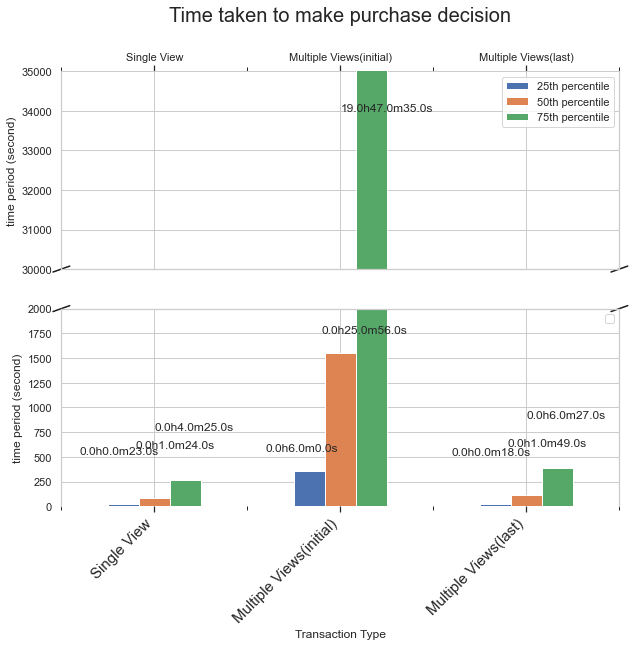

In [161]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,8))

# plot the same data on both axes
data.plot(ax=ax1, kind='bar')
data.plot(ax=ax2, kind='bar')

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(30000, 35000)  # outliers only
ax2.set_ylim(0, 2000)  # most of the data

# hide the spines between ax and ax2
ax1.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, ha="right", fontsize=15)
ax2.legend('')

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

x=[-0.4,-0.1,0]
for x,y,qt in zip(x,t_data['Single View'],q1time):
    plt.text(x, y+500, qt, fontsize=12)
x=[0.6,0.9,1]
for x,y,qt in zip(x,t_data['Multiple Views(initial)'],q2time):
    if x<1:
        plt.text(x, y+200, qt, fontsize=12)
    else:
        plt.text(x, 4000, qt, fontsize=12)
x=[1.6,1.9,2]
for x,y,qt in zip(x,t_data['Multiple Views(last)'],q3time):
    plt.text(x, y+500, qt, fontsize=12 )
ax1.set_ylabel('time period (second)')
ax2.set_ylabel('time period (second)')
ax1.set_title('Time taken to make purchase decision', pad=50, fontsize=20)
plt.show()

In [ ]:
### week and hour

In [162]:
purchase = df6[df6.purchase==1]

In [166]:
purchase['datetime'] = pd.to_datetime(purchase['datetime'])

<ipython-input-166-e180e790c9b6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase['datetime'] = pd.to_datetime(purchase['datetime'])


In [170]:
purchase['hour'] = purchase.datetime.dt.hour

<ipython-input-170-e79a4413ff45>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase['hour'] = purchase.datetime.dt.hour


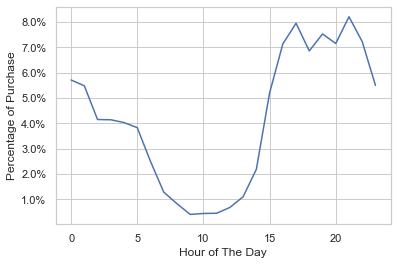

In [220]:
import matplotlib.ticker as mtick
#dayofweek = purchase[purchase.datetime.dt.date.astype('str')!='2015-07-03']
plt.plot(purchase.groupby('hour')['purchase'].sum()/purchase.shape[0]*100)
#plt.xticks(np.arange(7),['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of Purchase')
plt.xlabel('Hour of The Day')
plt.show()

In [167]:
purchase['weekday'] = purchase.datetime.dt.weekday

<ipython-input-167-66407afb831c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase['weekday'] = purchase.datetime.dt.weekday


In [ ]:
purchase.loc[purchase['weekday']==0, 'week_day'] = 'Monday'
purchase.loc[purchase['weekday']==1, 'week_day'] = 'Tuesday'
purchase.loc[purchase['weekday']==2, 'week_day'] = 'Wednesday'
purchase.loc[purchase['weekday']==3, 'week_day'] = 'Thursday'
purchase.loc[purchase['weekday']==4, 'week_day'] = 'Friday'
purchase.loc[purchase['weekday']==5, 'week_day'] = 'Saturday'
purchase.loc[purchase['weekday']==6, 'week_day'] = 'Sunday'

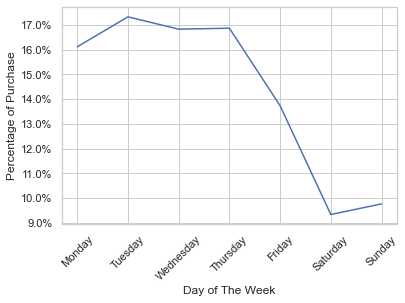

In [218]:
import matplotlib.ticker as mtick
dayofweek = purchase[purchase.datetime.dt.date.astype('str')!='2015-07-03']
plt.plot(dayofweek.groupby('weekday')['purchase'].sum()/dayofweek.shape[0]*100)
plt.xticks(np.arange(7),['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of Purchase')
plt.xlabel('Day of The Week')
plt.show()